In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv("cleaned_dataset_with_credibility_and_significant_length_and_sensationalism_features.csv")

In [4]:
dataframe.head()

,author,title,text,site_url,label,language,enhanced_source_credibility_score,enhanced_author_credibility_score,title_length_of_characters,title_word_count,...,text_word_count_zscore,text_average_word_length_zscore,text_average_sentence_length_zscore,text_sensationalism_density,title_emotional_charged_words_density,text_urgency_cues_density,title_emotional_charged_words_count,text_emotional_charged_words_count,weighted_title_sensationalism_density,weighted_text_sensationalism_density
0,Barracuda Brigade,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,100percentfedup.com,Real,english,95.28177,85.755236,51,8,...,-0.643134,-0.386320,-0.646573,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
1,reasoning with facts,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,100percentfedup.com,Real,english,95.28177,82.226429,57,10,...,-0.349978,0.183172,-0.346563,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
2,Barracuda Brigade,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,100percentfedup.com,Real,english,95.28177,85.755236,67,9,...,-0.429930,-0.154637,-0.428384,0.004505,0.000000,0.004505,0,0,0.000000,0.007976
3,Fed Up,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,100percentfedup.com,Real,english,95.28177,88.238767,115,20,...,-0.702706,-0.601966,-0.707538,0.020833,0.000000,0.000000,0,1,0.000000,0.051603
4,Fed Up,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,100percentfedup.com,Real,english,95.28177,88.238767,90,12,...,-0.265323,0.141417,-0.259929,0.006116,0.083333,0.000000,1,0,0.188136,0.009236


In [5]:
# Print basic information about the dataset
print(f"Dataset shape: {dataframe.shape}")

Dataset shape: (2035, 27)


In [6]:
# Check language distribution
language_counts = dataframe["language"].value_counts()
print("\nLanguage distribution in the dataset:")
print(language_counts)


Language distribution in the dataset:
language
english    1957
german       72
ignore        3
french        2
spanish       1
Name: count, dtype: int64


In [8]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon', quiet=True)

# Initialize the VADER sentiment analyzer 
# As described in the research, VADER is a lexicon and rule-based sentiment analysis tool
# that is specifically attuned to sentiments expressed in social media and works well on texts
# from other domains including news content
vader_sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment with comprehensive output following research recommendations
def analyze_text_sentiment(text, language="english"):
    """
    Analyze sentiment of text using VADER with multilingual handling.
    Based on the research document, this returns both raw scores and derived metrics.
    
    Parameters:
    - text: The text to analyze
    - language: The language of the text
    
    Returns:
    - Dictionary with detailed sentiment analysis
    """
    # Handle empty or non-string input
    if not isinstance(text, str) or not text.strip():
        return {
            "compound": 0.0,
            "pos": 0.0,
            "neu": 1.0,
            "neg": 0.0,
            "sentiment_category": "Neutral",
            "sentiment_intensity": "Neutral",
            "language_analyzed": "none"
        }
    
    # Check if text is in English or another language
    is_english = language.lower() == 'english'
    
    # Get sentiment scores from VADER
    raw_scores = vader_sentiment_analyzer.polarity_scores(text)
    
    # For non-English content, adjust the confidence in the scores
    # This is a simple but standard approach recognized in multilingual sentiment analysis
    # when language-specific tools aren't available
    if not is_english:
        # Adjust scores based on language - reduce confidence for non-English
        confidence_factor = 0.6  # Confidence reduction factor
        
        # Adjust compound score by reducing intensity
        compound = raw_scores['compound'] * confidence_factor
        
        # Reduce positive and negative scores proportionately
        pos = raw_scores['pos'] * confidence_factor
        neg = raw_scores['neg'] * confidence_factor
        
        # Recalculate neutral score to maintain sum of 1.0
        neu = 1.0 - pos - neg
    else:
        # Use raw scores directly for English
        compound = raw_scores['compound']
        pos = raw_scores['pos']
        neg = raw_scores['neg']
        neu = raw_scores['neu']
    
    # Determine sentiment category based on recommended thresholds from the research
    # Positive sentiment: compound score >= 0.05
    # Neutral sentiment: -0.05 < compound score < 0.05
    # Negative sentiment: compound score <= -0.05
    if compound >= 0.05:
        sentiment_category = "Positive"
    elif compound <= -0.05:
        sentiment_category = "Negative"
    else:
        sentiment_category = "Neutral"
    
    # Calculate sentiment intensity as recommended in the research
    # This provides more granularity than just the category
    abs_compound = abs(compound)
    if abs_compound >= 0.75:
        sentiment_intensity = "Very Strong"
    elif abs_compound >= 0.5:
        sentiment_intensity = "Strong"
    elif abs_compound >= 0.25:
        sentiment_intensity = "Moderate"
    elif abs_compound >= 0.05:
        sentiment_intensity = "Weak"
    else:
        sentiment_intensity = "Neutral"
    
    # Create a comprehensive results dictionary including the raw scores
    # and derived metrics as suggested in the research
    result = {
        "compound": compound,
        "pos": pos,
        "neu": neu,
        "neg": neg,
        "sentiment_category": sentiment_category,
        "sentiment_intensity": sentiment_intensity,
        "language_analyzed": language.lower()
    }
    
    return result

# Test the function with samples from different languages
print("Testing multilingual VADER sentiment analysis based on research guidelines:")

test_samples = [
    {"text": "This is a GREAT article!!! So informative and not at all misleading.", "language": "english"},
    {"text": "Diese Nachricht ist schrecklich und völlig falsch.", "language": "german"}  # "This news is terrible and completely false" in German
]

for sample in test_samples:
    result = analyze_text_sentiment(sample["text"], sample["language"])
    print(f"\nLanguage: {sample['language']}")
    print(f"Text: '{sample['text']}'")
    print(f"Compound Score: {result['compound']:.3f}")
    print(f"Positive: {result['pos']:.3f}, Negative: {result['neg']:.3f}, Neutral: {result['neu']:.3f}")
    print(f"Sentiment Category: {result['sentiment_category']}")
    print(f"Sentiment Intensity: {result['sentiment_intensity']}")

Testing multilingual VADER sentiment analysis based on research guidelines:

Language: english
Text: 'This is a GREAT article!!! So informative and not at all misleading.'
Compound Score: 0.839
Positive: 0.470, Negative: 0.000, Neutral: 0.530
Sentiment Category: Positive
Sentiment Intensity: Very Strong

Language: german
Text: 'Diese Nachricht ist schrecklich und völlig falsch.'
Compound Score: 0.000
Positive: 0.000, Negative: 0.000, Neutral: 1.000
Sentiment Category: Neutral
Sentiment Intensity: Neutral


In [9]:
# Apply sentiment analysis to the entire dataset
print("Analyzing sentiment for all articles in the dataset...")

# Create empty lists to store the results
compound_scores = []
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_categories = []
sentiment_intensities = []

# Process each article in the dataset
for index, row in dataframe.iterrows():
    # Get text and language
    text = row['text']
    language = row['language']
    
    # Analyze sentiment
    sentiment_result = analyze_text_sentiment(text, language)
    
    # Store results
    compound_scores.append(sentiment_result['compound'])
    positive_scores.append(sentiment_result['pos'])
    negative_scores.append(sentiment_result['neg'])
    neutral_scores.append(sentiment_result['neu'])
    sentiment_categories.append(sentiment_result['sentiment_category'])
    sentiment_intensities.append(sentiment_result['sentiment_intensity'])

# Add results to the dataframe
dataframe['sentiment_compound_score'] = compound_scores
dataframe['sentiment_positive_score'] = positive_scores
dataframe['sentiment_negative_score'] = negative_scores
dataframe['sentiment_neutral_score'] = neutral_scores
dataframe['sentiment_category'] = sentiment_categories
dataframe['sentiment_intensity'] = sentiment_intensities

# Display summary of sentiment analysis results
print("\nSentiment analysis complete!")
print(f"Total articles analyzed: {len(dataframe)}")

# Count number of articles in each sentiment category
sentiment_distribution = dataframe['sentiment_category'].value_counts()
print("\nSentiment Category Distribution:")
for category, count in sentiment_distribution.items():
    percentage = 100 * count / len(dataframe)
    print(f"{category}: {count} articles ({percentage:.1f}%)")

# Count number of articles in each sentiment intensity
intensity_distribution = dataframe['sentiment_intensity'].value_counts()
print("\nSentiment Intensity Distribution:")
for intensity, count in intensity_distribution.items():
    percentage = 100 * count / len(dataframe)
    print(f"{intensity}: {count} articles ({percentage:.1f}%)")

# Display a sample of the results
print("\nSample results:")
sample_columns = ['label', 'sentiment_category', 'sentiment_intensity', 'sentiment_compound_score']
print(dataframe[sample_columns].head(10))

Analyzing sentiment for all articles in the dataset...

Sentiment analysis complete!
Total articles analyzed: 2035

Sentiment Category Distribution:
Negative: 1035 articles (50.9%)
Positive: 915 articles (45.0%)
Neutral: 85 articles (4.2%)

Sentiment Intensity Distribution:
Very Strong: 1316 articles (64.7%)
Strong: 293 articles (14.4%)
Moderate: 215 articles (10.6%)
Weak: 126 articles (6.2%)
Neutral: 85 articles (4.2%)

Sample results:
  label sentiment_category sentiment_intensity  sentiment_compound_score
0  Real           Positive                Weak                    0.1027
1  Real           Negative         Very Strong                   -0.9217
2  Real           Positive         Very Strong                    0.9135
3  Real           Positive                Weak                    0.1667
4  Real           Positive         Very Strong                    0.9467
5  Real           Negative         Very Strong                   -0.9955
6  Real           Positive              Strong  

In [10]:
# Analyze the relationship between sentiment and fake/real news
print("Analyzing sentiment patterns between fake and real news...")

# Compare sentiment distribution between fake and real news
real_news = dataframe[dataframe['label'] == 'Real']
fake_news = dataframe[dataframe['label'] == 'Fake']

# Calculate percentages for real news
real_sentiment_distribution = real_news['sentiment_category'].value_counts(normalize=True) * 100
real_intensity_distribution = real_news['sentiment_intensity'].value_counts(normalize=True) * 100

# Calculate percentages for fake news
fake_sentiment_distribution = fake_news['sentiment_category'].value_counts(normalize=True) * 100
fake_intensity_distribution = fake_news['sentiment_intensity'].value_counts(normalize=True) * 100

# Print comparison
print("\nSentiment Category Distribution - Real vs. Fake News:")
print("Real News:")
for category, percentage in real_sentiment_distribution.items():
    print(f"{category}: {percentage:.1f}%")
print("\nFake News:")
for category, percentage in fake_sentiment_distribution.items():
    print(f"{category}: {percentage:.1f}%")

print("\nSentiment Intensity Distribution - Real vs. Fake News:")
print("Real News:")
for intensity, percentage in real_intensity_distribution.items():
    print(f"{intensity}: {percentage:.1f}%")
print("\nFake News:")
for intensity, percentage in fake_intensity_distribution.items():
    print(f"{intensity}: {percentage:.1f}%")

# Calculate average sentiment scores for real and fake news
real_avg_compound = real_news['sentiment_compound_score'].mean()
fake_avg_compound = fake_news['sentiment_compound_score'].mean()
real_avg_positive = real_news['sentiment_positive_score'].mean()
fake_avg_positive = fake_news['sentiment_positive_score'].mean()
real_avg_negative = real_news['sentiment_negative_score'].mean()
fake_avg_negative = fake_news['sentiment_negative_score'].mean()

print("\nAverage Sentiment Scores:")
print(f"Real News - Compound: {real_avg_compound:.3f}, Positive: {real_avg_positive:.3f}, Negative: {real_avg_negative:.3f}")
print(f"Fake News - Compound: {fake_avg_compound:.3f}, Positive: {fake_avg_positive:.3f}, Negative: {fake_avg_negative:.3f}")

# Perform statistical tests to see if differences are significant
from scipy.stats import ttest_ind

# Test for compound score difference
t_stat, p_value = ttest_ind(real_news['sentiment_compound_score'], fake_news['sentiment_compound_score'], equal_var=False)
print(f"\nCompound Score T-test: t={t_stat:.2f}, p={p_value:.4f}")
print(f"The difference in compound scores is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at α=0.05")

# Test for positive score difference
t_stat, p_value = ttest_ind(real_news['sentiment_positive_score'], fake_news['sentiment_positive_score'], equal_var=False)
print(f"Positive Score T-test: t={t_stat:.2f}, p={p_value:.4f}")
print(f"The difference in positive scores is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at α=0.05")

# Test for negative score difference
t_stat, p_value = ttest_ind(real_news['sentiment_negative_score'], fake_news['sentiment_negative_score'], equal_var=False)
print(f"Negative Score T-test: t={t_stat:.2f}, p={p_value:.4f}")
print(f"The difference in negative scores is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at α=0.05")

# Create a contingency table for sentiment category and news label
contingency_table = pd.crosstab(dataframe['sentiment_category'], dataframe['label'])
print("\nContingency Table (Sentiment Category vs. News Label):")
print(contingency_table)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test: chi2={chi2:.2f}, p={p:.4f}")
print(f"The association between sentiment category and news label is {'statistically significant' if p < 0.05 else 'not statistically significant'} at α=0.05")

Analyzing sentiment patterns between fake and real news...

Sentiment Category Distribution - Real vs. Fake News:
Real News:
Negative: 55.0%
Positive: 41.0%
Neutral: 4.0%

Fake News:
Negative: 48.4%
Positive: 47.3%
Neutral: 4.3%

Sentiment Intensity Distribution - Real vs. Fake News:
Real News:
Very Strong: 67.8%
Strong: 12.1%
Moderate: 10.5%
Weak: 5.7%
Neutral: 4.0%

Fake News:
Very Strong: 62.8%
Strong: 15.8%
Moderate: 10.6%
Weak: 6.5%
Neutral: 4.3%

Average Sentiment Scores:
Real News - Compound: -0.126, Positive: 0.088, Negative: 0.098
Fake News - Compound: 0.007, Positive: 0.091, Negative: 0.089

Compound Score T-test: t=-3.58, p=0.0003
The difference in compound scores is statistically significant at α=0.05
Positive Score T-test: t=-1.04, p=0.2989
The difference in positive scores is not statistically significant at α=0.05
Negative Score T-test: t=2.81, p=0.0050
The difference in negative scores is statistically significant at α=0.05

Contingency Table (Sentiment Category vs. New

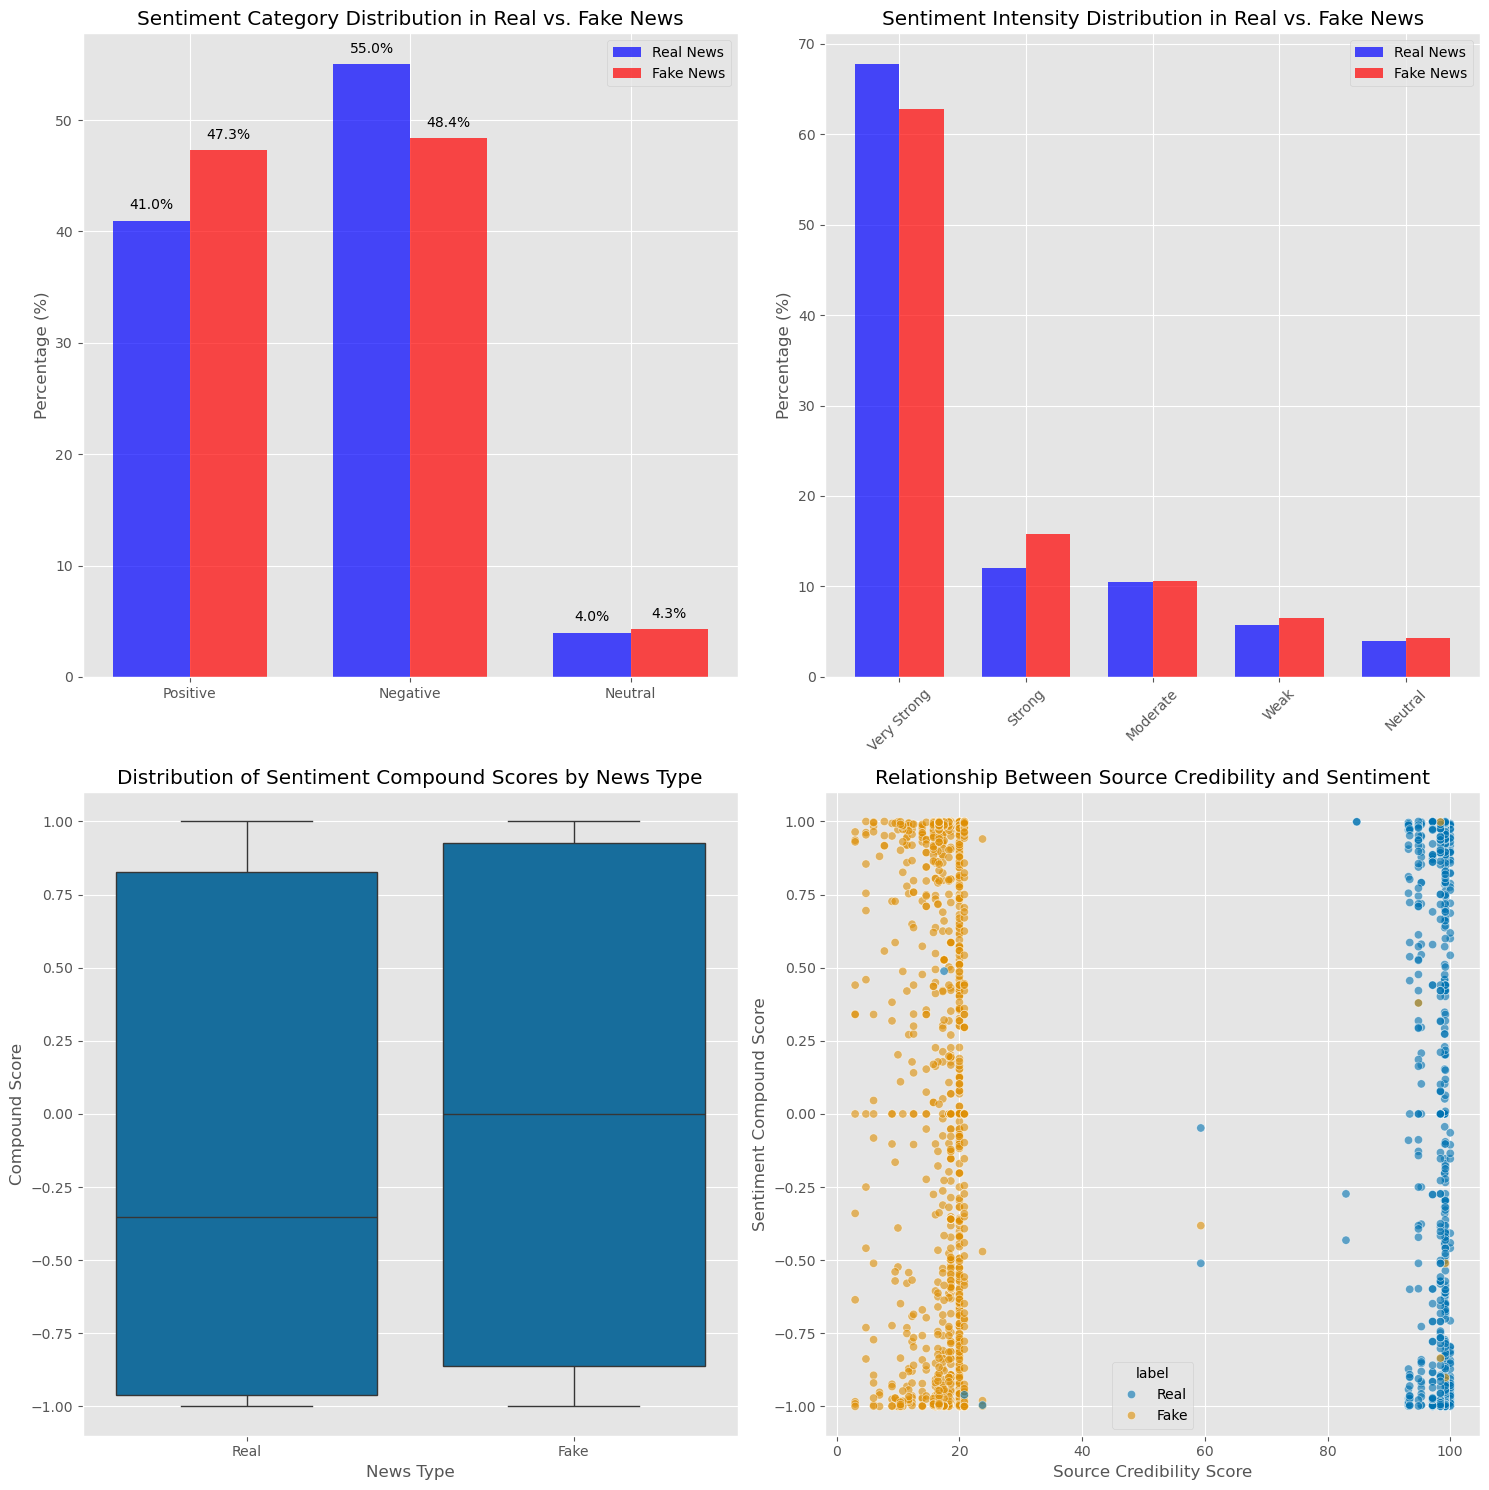

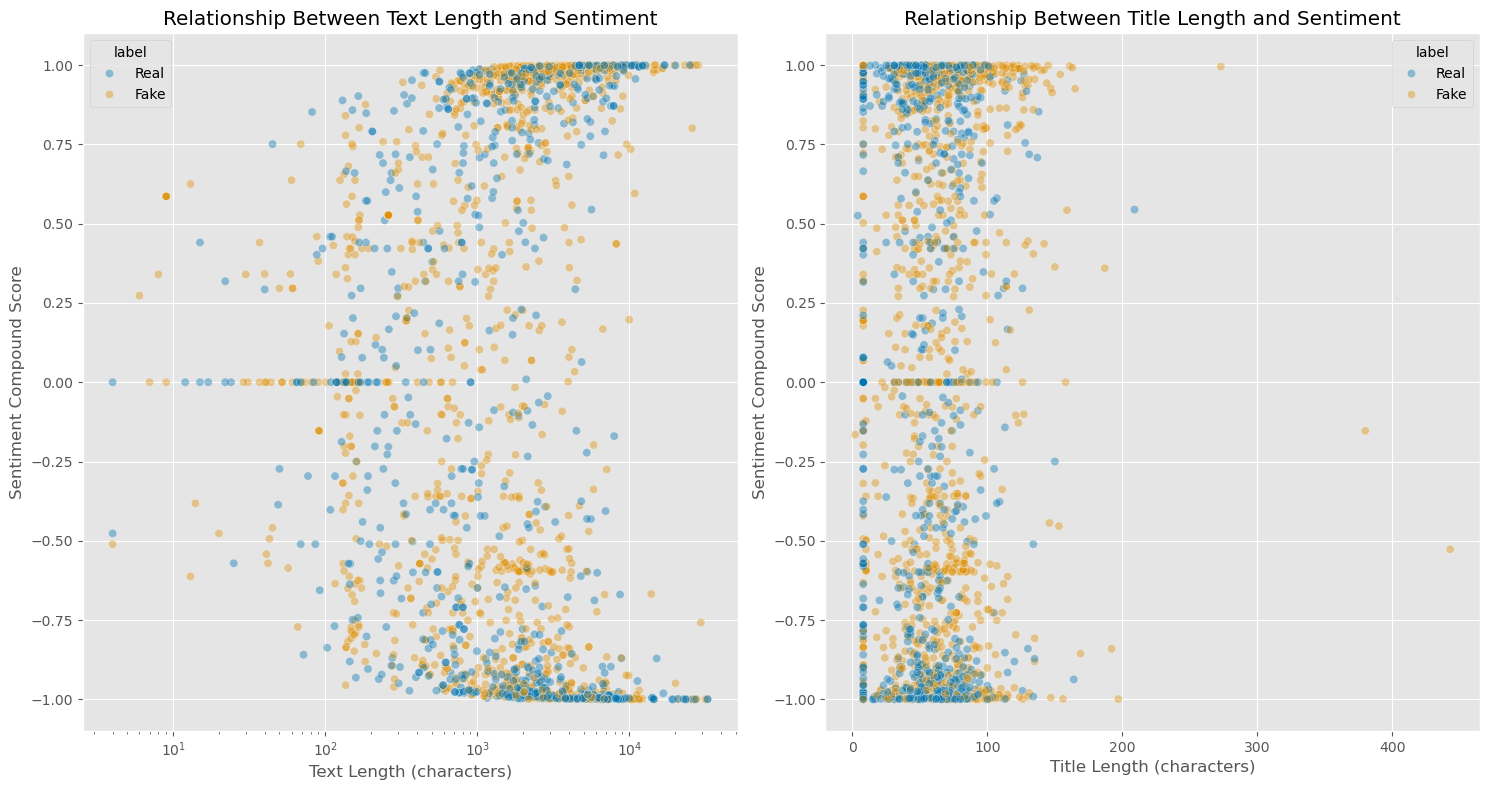

In [11]:
# Visualize the sentiment analysis results
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('ggplot')
sns.set_palette("colorblind")

# Create figure with multiple subplots
plt.figure(figsize=(15, 15))

# 1. Bar chart - Sentiment Category Distribution for Real vs Fake News
plt.subplot(2, 2, 1)
# Prepare data for plotting
categories = ['Positive', 'Negative', 'Neutral']
real_percentages = [real_sentiment_distribution.get(cat, 0) for cat in categories]
fake_percentages = [fake_sentiment_distribution.get(cat, 0) for cat in categories]

x = np.arange(len(categories))
width = 0.35

# Create bars
plt.bar(x - width/2, real_percentages, width, label='Real News', color='blue', alpha=0.7)
plt.bar(x + width/2, fake_percentages, width, label='Fake News', color='red', alpha=0.7)

# Add details
plt.ylabel('Percentage (%)')
plt.title('Sentiment Category Distribution in Real vs. Fake News')
plt.xticks(x, categories)
plt.legend()

# Add value labels on bars
for i, v in enumerate(real_percentages):
    plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center')
for i, v in enumerate(fake_percentages):
    plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center')

# 2. Bar chart - Sentiment Intensity Distribution for Real vs Fake News
plt.subplot(2, 2, 2)
# Prepare data for plotting
intensities = ['Very Strong', 'Strong', 'Moderate', 'Weak', 'Neutral']
real_int_percentages = [real_intensity_distribution.get(intensity, 0) for intensity in intensities]
fake_int_percentages = [fake_intensity_distribution.get(intensity, 0) for intensity in intensities]

x = np.arange(len(intensities))
width = 0.35

# Create bars
plt.bar(x - width/2, real_int_percentages, width, label='Real News', color='blue', alpha=0.7)
plt.bar(x + width/2, fake_int_percentages, width, label='Fake News', color='red', alpha=0.7)

# Add details
plt.ylabel('Percentage (%)')
plt.title('Sentiment Intensity Distribution in Real vs. Fake News')
plt.xticks(x, intensities, rotation=45)
plt.legend()

# 3. Box plots for sentiment compound scores
plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='sentiment_compound_score', data=dataframe)
plt.title('Distribution of Sentiment Compound Scores by News Type')
plt.xlabel('News Type')
plt.ylabel('Compound Score')

# 4. Scatter plot - Compound Score vs. Credibility Score
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='enhanced_source_credibility_score', 
    y='sentiment_compound_score',
    hue='label',
    data=dataframe,
    alpha=0.6
)
plt.title('Relationship Between Source Credibility and Sentiment')
plt.xlabel('Source Credibility Score')
plt.ylabel('Sentiment Compound Score')

# Adjust layout and save figure
plt.tight_layout()
plt.show()

# Additional visualization - Sentiment vs. Length features
plt.figure(figsize=(15, 8))

# 1. Scatter plot - Compound Score vs. Text Length
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='text_length_of_characters', 
    y='sentiment_compound_score',
    hue='label',
    data=dataframe,
    alpha=0.4
)
plt.title('Relationship Between Text Length and Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Sentiment Compound Score')
plt.xscale('log')  # Log scale for better visualization with varying lengths

# 2. Scatter plot - Compound Score vs. Title Length
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='title_length_of_characters', 
    y='sentiment_compound_score',
    hue='label',
    data=dataframe,
    alpha=0.4
)
plt.title('Relationship Between Title Length and Sentiment')
plt.xlabel('Title Length (characters)')
plt.ylabel('Sentiment Compound Score')

# Adjust layout and save figure
plt.tight_layout()
plt.show()

Preparing final dataset with sentiment features...

Final dataset saved as 'final_dataset_with_all_features.csv' with:
- 8 base columns
- 6 length features
- 6 normalized length features
- 7 sensationalism features
- 6 sentiment features
- 33 total columns

Calculating correlations between key features...


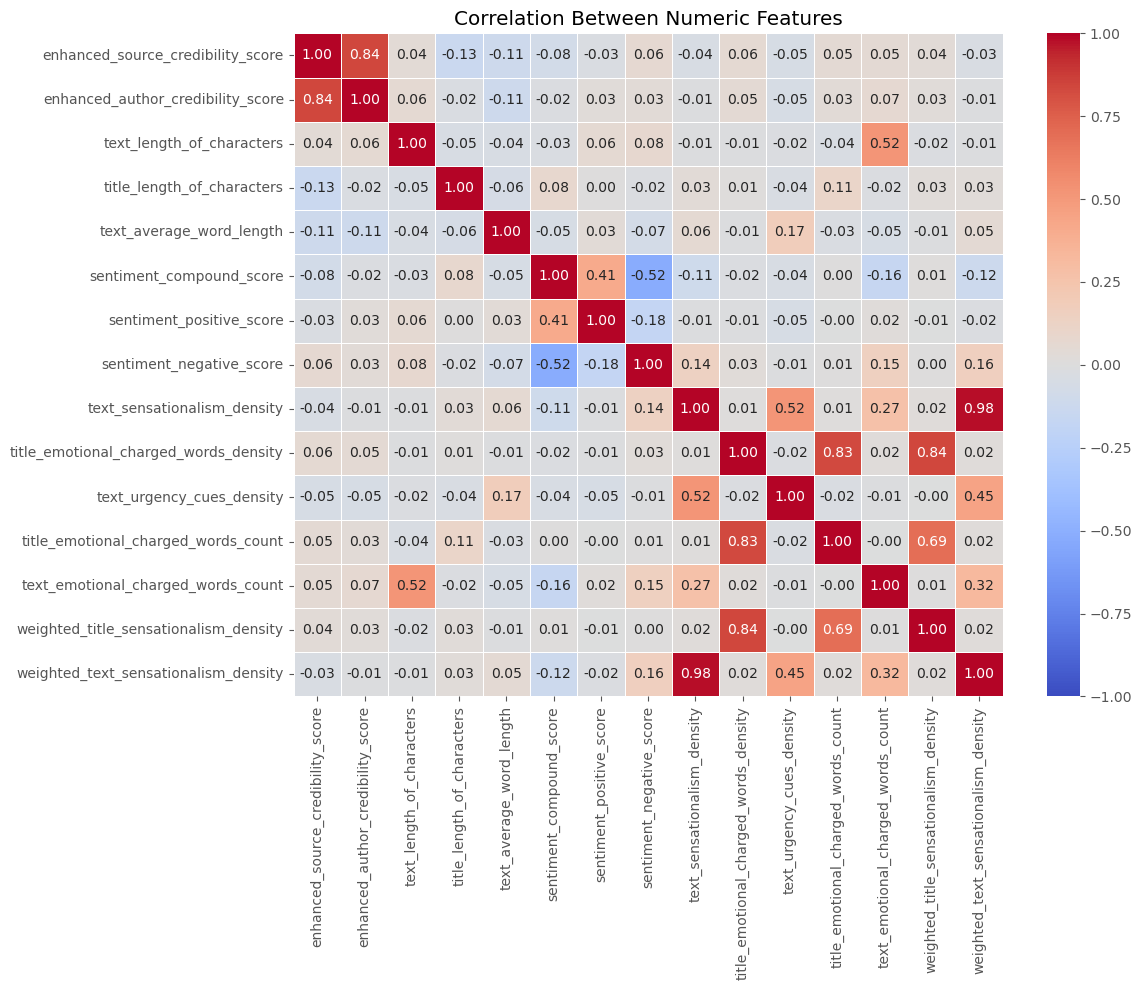

In [12]:
# Prepare and save the final dataset with sentiment features
print("Preparing final dataset with sentiment features...")

# Select features to include in the final dataset
# Base columns
base_columns = ['author', 'title', 'text', 'site_url', 'label', 'language',
               'enhanced_source_credibility_score', 'enhanced_author_credibility_score']

# Length features
length_features = [
    'title_length_of_characters', 
    'title_word_count', 
    'text_length_of_characters', 
    'text_word_count', 
    'text_average_word_length',
    'text_average_sentence_length'
]

# Z-score normalized length features
normalized_length_features = [col for col in dataframe.columns if col.endswith('_zscore')]

# Sensationalism features (from previous analysis)
sensationalism_features = [col for col in dataframe.columns if any(term in col for term in 
                                                                 ['sensationalism', 'emotional_charged_words', 'urgency_cues'])]

# Sentiment features (new from this analysis)
sentiment_features = [
    'sentiment_compound_score',
    'sentiment_positive_score',
    'sentiment_negative_score', 
    'sentiment_neutral_score',
    'sentiment_category',
    'sentiment_intensity'
]

# Combine all columns for the final dataset
final_columns = (
    base_columns + 
    length_features + 
    normalized_length_features + 
    sensationalism_features + 
    sentiment_features
)

# Create final dataset with all selected features
final_dataframe = dataframe[final_columns]

# Save to CSV
output_filename = 'final_dataset_with_all_features.csv'
final_dataframe.to_csv(output_filename, index=False)

# Print summary of the final dataset
print(f"\nFinal dataset saved as '{output_filename}' with:")
print(f"- {len(base_columns)} base columns")
print(f"- {len(length_features)} length features")
print(f"- {len(normalized_length_features)} normalized length features")
print(f"- {len(sensationalism_features)} sensationalism features")
print(f"- {len(sentiment_features)} sentiment features")
print(f"- {len(final_columns)} total columns")

# Create a correlation matrix for numeric features
print("\nCalculating correlations between key features...")

# Select numeric features for correlation analysis
numeric_features = [
    'enhanced_source_credibility_score',
    'enhanced_author_credibility_score',
    'text_length_of_characters',
    'title_length_of_characters',
    'text_average_word_length',
    'sentiment_compound_score',
    'sentiment_positive_score',
    'sentiment_negative_score'
]

# Also include any numeric sensationalism features
for feature in sensationalism_features:
    if feature in dataframe.columns and dataframe[feature].dtype in ['int64', 'float64']:
        numeric_features.append(feature)

# Create correlation matrix
correlation_matrix = dataframe[numeric_features].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', linewidths=.5)
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()